# <center> Sequential MUD estimation - Monomial Test Case </center>

___
<font color='blue'><center>**Carlos del-Castillo-Negrete, Rylan Spence**</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu, rylan.spence@utexas.edu</center>
___

- [***Parameter Estimation with Maximal Updated Densities***](https://arxiv.org/pdf/2212.04587.pdf) Pilosov, M., del-Castillo-Negrete, C., Yen, T. Y., Butler, T., & Dawson, C. (2022). Parameter Estimation with Maximal Updated Densities. arXiv preprint arXiv:2212.04587.
___


<cite id="e9b62"><a href="#zotero%7C11450669%2F7F6J6S7U">(Wicks &#38; Atkinson, 2017)</a></cite>


____

Consider N-dimensional where each dimension is monomial with:
   
   $$ \Large \Lambda = [-1, 1] \in \mathbb{R} $$  
   
   $$ \Large Q_i(\lambda) = \lambda_i^p \rightarrow \mathcal{D} = [-1, 1] $$
   
for each dimension $i$ and an exponent $p$.

We assume:

   $\pi_{in} \sim \mathcal{U}([-1, 1])$
  
   $\pi_{ob} \sim \mathcal{N}(0.25,0.1^2)$

# Static Models

## 2D monomial

[08/03/23 13:47:06] INFO     Logger initialized                                                           ]8;id=688983;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=995142;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#78\78]8;;\

                    INFO     Getting data for model from 0.0 to 3.0.                                   ]8;id=422774;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=506845;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#327\327]8;;\

                    INFO     Drawing 2 from uniform at:                                                ]8;id=304506;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=349441;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#521\521]8;;\
                                     loc: [0.15 0.4 ]                                                              
                                     scale: [0.3 0.8]                                                              

                    INFO     Beginning forward solve from 0.0 to 3.0                                   ]8;id=146600;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=497119;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#390\390]8;;\

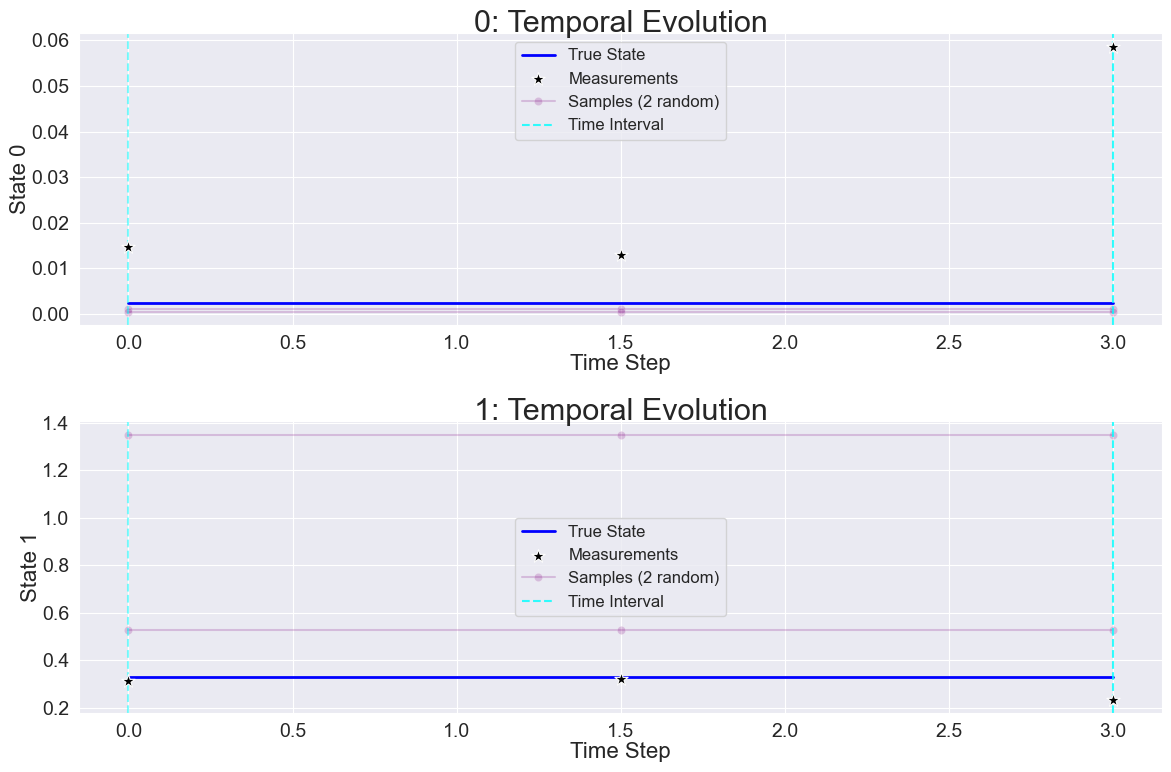

In [1]:
import pandas as pd, numpy as np
from pydci.log import enable_log, disable_log
import pydci.examples.monomial as mon
import importlib

importlib.reload(mon)


enable_log(level='INFO')

# * Initialize Problem
mm2 = mon.Monomial2D(p=5)

# * Pull synthetic data
mm2.get_data(t0=0.0, tf=3.0)

# * Forward solve samples from an initial 
pi_in, samples = mm2.get_uniform_initial_samples(num_samples=2, scale=0.5)
mm2.forward_solve(samples=samples)

# * Plot true, observe, and predicted states
mm2.plot_states()

In [2]:
mm2.samples[0], mm2.samples_xf

(      lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2   q_lam_3   q_lam_4  \
 0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025   
 1  0.218488  1.061928  0.000498  1.350441  0.000498  1.350441  0.000498   
 
     q_lam_5  
 0  0.527526  
 1  1.350441  ,
 [array([[1.02489283e-03, 5.27526135e-01],
         [4.97899948e-04, 1.35044126e+00]])])

In [3]:
# Append samples
_, samples_1 = mm2.get_uniform_initial_samples(num_samples=2, scale=0.5)
mm2.forward_solve(samples=samples_1, append=True)

                    INFO     Drawing 2 from uniform at:                                                ]8;id=851040;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=810394;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#521\521]8;;\
                                     loc: [0.15 0.4 ]                                                              
                                     scale: [0.3 0.8]                                                              

                    INFO     Beginning forward solve from 0.0 to 3.0                                   ]8;id=722796;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=409993;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#390\390]8;;\

                    INFO     samples_xf: [[0.00039967 0.09032493]                                      ]8;id=63044;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=342703;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#444\444]8;;\
                              [0.00231021 0.23606337]]                                                             

                    INFO     previous: [[1.02489283e-03 5.27526135e-01]                                ]8;id=461157;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=931466;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#445\445]8;;\
                              [4.97899948e-04 1.35044126e+00]]                                                     

In [4]:
mm2.samples[0], mm2.samples_xf

(      lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2   q_lam_3   q_lam_4  \
 0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025   
 1  0.218488  1.061928  0.000498  1.350441  0.000498  1.350441  0.000498   
 2  0.209093  0.618246  0.000400  0.090325  0.000400  0.090325  0.000400   
 3  0.296982  0.749214  0.002310  0.236063  0.002310  0.236063  0.002310   
 
     q_lam_5  
 0  0.527526  
 1  1.350441  
 2  0.090325  
 3  0.236063  ,
 [array([[1.02489283e-03, 5.27526135e-01],
         [4.97899948e-04, 1.35044126e+00],
         [3.99667086e-04, 9.03249262e-02],
         [2.31021232e-03, 2.36063368e-01]])])

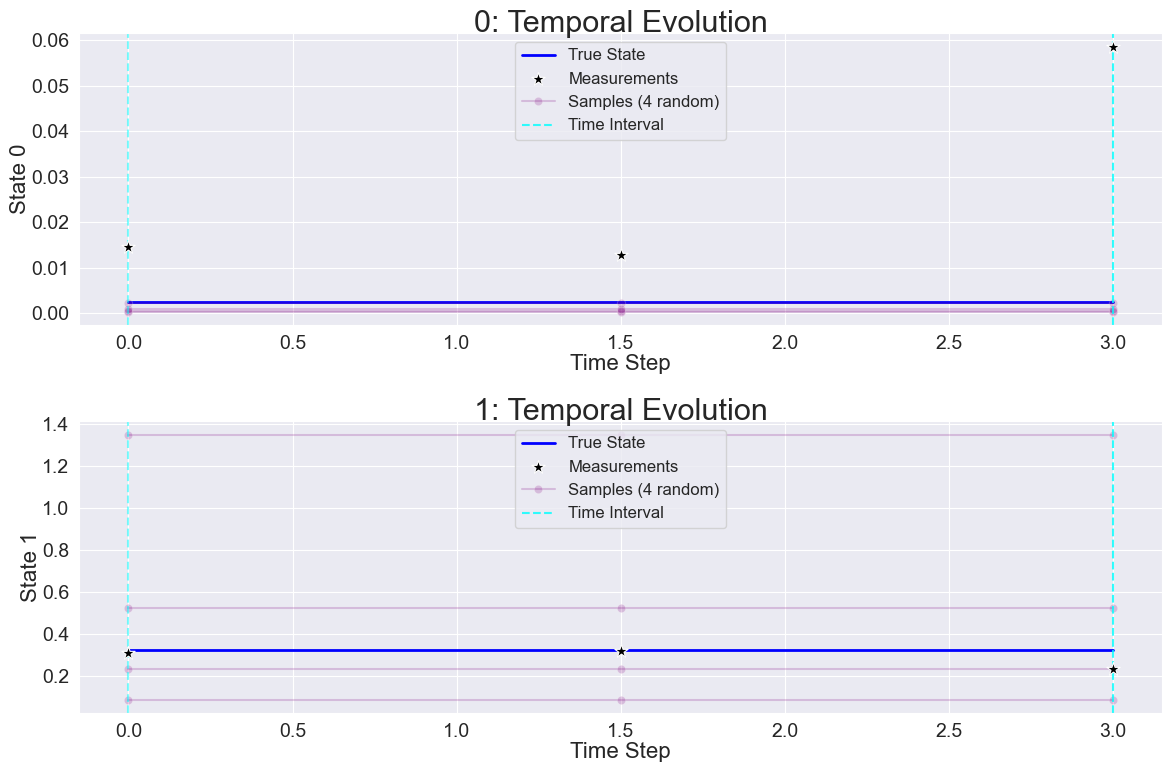

In [5]:
mm2.plot_states()

In [6]:
mm2.samples[0]

,lam_0,lam_1,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5
0,0.252427,0.879931,0.001025,0.527526,0.001025,0.527526,0.001025,0.527526
1,0.218488,1.061928,0.000498,1.350441,0.000498,1.350441,0.000498,1.350441
2,0.209093,0.618246,0.000400,0.090325,0.000400,0.090325,0.000400,0.090325
3,0.296982,0.749214,0.002310,0.236063,0.002310,0.236063,0.002310,0.236063


                    INFO     Getting data for model from 3.0 to 6.                                     ]8;id=485963;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=128742;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#327\327]8;;\

                    INFO     Beginning forward solve from 3.0 to 6.0                                   ]8;id=90194;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=984961;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#390\390]8;;\

                    INFO     No samples passed. Resuming previous 4 samples                            ]8;id=896920;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=132710;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#396\396]8;;\

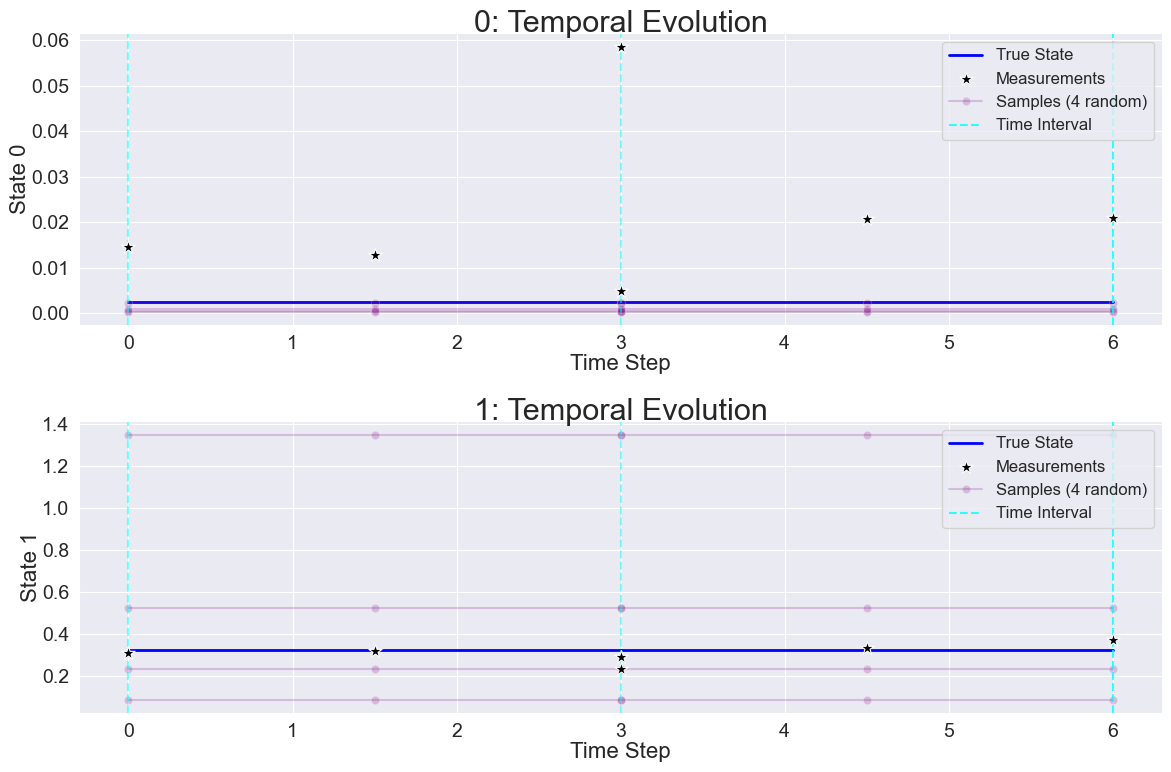

In [7]:
mm2.get_data(tf=6)
mm2.forward_solve()
# TODO: Fix plot-states: The lines should be the same throughout iterations since no new samples and constant model
mm2.plot_states()

In [8]:
mm2.samples[1], mm2.samples[0]

(      lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2   q_lam_3   q_lam_4  \
 0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025   
 1  0.218488  1.061928  0.000498  1.350441  0.000498  1.350441  0.000498   
 2  0.209093  0.618246  0.000400  0.090325  0.000400  0.090325  0.000400   
 3  0.296982  0.749214  0.002310  0.236063  0.002310  0.236063  0.002310   
 
     q_lam_5  
 0  0.527526  
 1  1.350441  
 2  0.090325  
 3  0.236063  ,
       lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2   q_lam_3   q_lam_4  \
 0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025   
 1  0.218488  1.061928  0.000498  1.350441  0.000498  1.350441  0.000498   
 2  0.209093  0.618246  0.000400  0.090325  0.000400  0.090325  0.000400   
 3  0.296982  0.749214  0.002310  0.236063  0.002310  0.236063  0.002310   
 
     q_lam_5  
 0  0.527526  
 1  1.350441  
 2  0.090325  
 3  0.236063  )

In [9]:
# Get attributes in dmm2
import pandas as pd
import numpy as np
[x for x in dir(mm2) if (type(getattr(mm2, x)) in [int, float, str, bool, list, pd.DataFrame, np.ndarray]) and not x.startswith('_')]

['MAX_STATES',
 'data',
 'lam_true',
 'measurement_noise',
 'n_params',
 'n_sensors',
 'n_states',
 'p',
 'sample_ts',
 'samples',
 'samples_xf',
 'solve_ts',
 'state_idxs',
 'x0']

# Saving and Loading State

In [10]:
enable_log(level='DEBUG')
mm2.save('test.h5', overwrite=True)

[08/03/23 13:47:07] INFO     Logger initialized                                                           ]8;id=618157;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=762794;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#78\78]8;;\

                    DEBUG    Saving data as DataFrame                                                  ]8;id=375545;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=458693;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#202\202]8;;\

                    DEBUG    Saving samples as DataFrame                                               ]8;id=794723;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=214158;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#202\202]8;;\

                    DEBUG    Saving samples_xf as DataFrame                                            ]8;id=784922;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=343254;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#202\202]8;;\

/Users/carlos/repos/pyDCI/src/pydci/Model.py:212: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  store.put("__attrs__", pd.Series(info_dict))


[08/03/23 13:47:07] INFO     Logger initialized                                                           ]8;id=256224;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=235048;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#78\78]8;;\

                    INFO     Saving model state to file at                                             ]8;id=586722;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=463481;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#143\143]8;;\
                             /Users/carlos/repos/pyDCI/notebooks/Examples/test.h5                                  

                    DEBUG    type(/__attrs__) = <class 'tables.group.Group'>                           ]8;id=19639;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=391560;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#148\148]8;;\
                              ?= DataframeDF -> False                                                              
                              ? = Series -> True                                                                   
                              ? = dict -> False                                                                    

                    DEBUG    type(/data) = <class 'tables.group.Group'>                                ]8;id=129852;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=49676;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#148\148]8;;\
                              ?= DataframeDF -> True                                                               
                              ? = Series -> False                                                                  
                              ? = dict -> False                                                                    

                    DEBUG    DF: /data:[    ts  shift_idx  sample_flag  lam_true_0  q_lam_true_0       ]8;id=983371;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=466856;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#158\158]8;;\
                             q_lam_true_1  \                                                                       
                             0  0.0          0         True         0.3       0.00243       0.32768                
                                                                                                                   
                                q_lam_obs_0  q_lam_obs_1                                                           
                             0     0.014661     0.314052  ,     ts  shift_idx  sample_flag  lam_true_0             
                             q_lam_true_0  q_lam_true_1  \                                                         
                             0  3.0          0         True         0.3       0.00243       0.32768                
                                                                                                                   
                                q_lam_obs_0  q_lam_obs_1                                                           
                             0     0.004897      0.29504  ]                                                        

                    DEBUG    type(/samples) = <class 'tables.group.Group'>                             ]8;id=675980;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=21634;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#148\148]8;;\
                              ?= DataframeDF -> True                                                               
                              ? = Series -> False                                                                  
                              ? = dict -> False                                                                    

                    DEBUG    DF: /samples:[      lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2         ]8;id=725465;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=503882;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#158\158]8;;\
                             q_lam_3   q_lam_4  \                                                                  
                             0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025               
                                                                                                                   
                                 q_lam_5                                                                           
                             0  0.527526  ,       lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2                    
                             q_lam_3   q_lam_4  \                                                                  
                             0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025               
                                                                                                                   
                                 q_lam_5                                                                           
                             0  0.527526  ]                                                                        

                    DEBUG    type(/samples_xf) = <class 'tables.group.Group'>                          ]8;id=379572;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=912751;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#148\148]8;;\
                              ?= DataframeDF -> True                                                               
                              ? = Series -> False                                                                  
                              ? = dict -> False                                                                    

                    DEBUG    DF: /samples_xf:[          0         1                                    ]8;id=42398;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=80429;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#158\158]8;;\
                             0  0.001025  0.527526,           0         1                                          
                             0  0.001025  0.527526]                                                                

                    DEBUG    Setting info attributes of 7                                              ]8;id=630968;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=264788;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#167\167]8;;\

                    DEBUG    Setting attr lam_true to [0.3 0.8]                                        ]8;id=940836;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=847063;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#169\169]8;;\

                    DEBUG    Setting attr measurement_noise to 0.05                                    ]8;id=295969;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=251587;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#169\169]8;;\

                    DEBUG    Setting attr p to 5                                                       ]8;id=90142;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=100222;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#169\169]8;;\

                    DEBUG    Setting attr sample_ts to 1.0                                             ]8;id=440045;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=975467;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#169\169]8;;\

                    DEBUG    Setting attr solve_ts to 1.0                                              ]8;id=15118;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=318474;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#169\169]8;;\

                    DEBUG    Setting attr state_idxs to [0 1]                                          ]8;id=986572;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=782436;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#169\169]8;;\

                    DEBUG    Setting attr x0 to [0, 0]                                                 ]8;id=449494;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=123306;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#169\169]8;;\

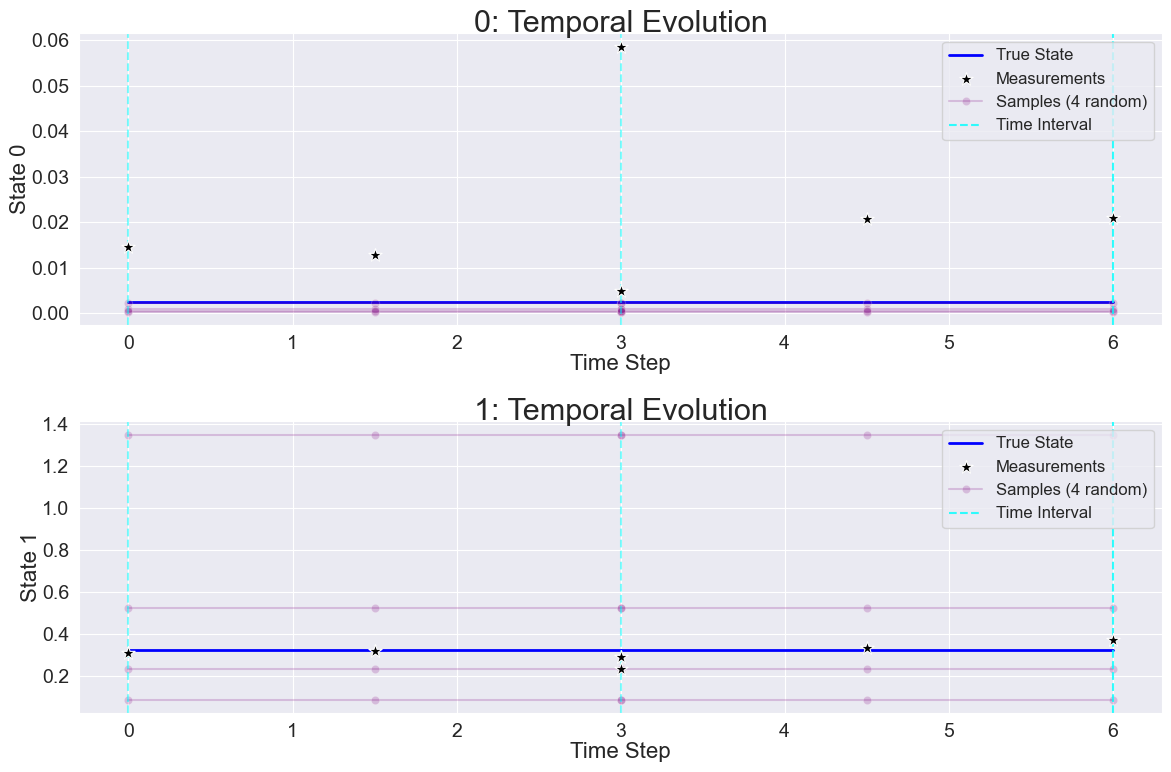

In [11]:
enable_log(level='DEBUG')
mm2_load = mon.Monomial2D(file='test.h5')

mm2_load.plot_states()

In [12]:
mm2_load.samples

[      lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2   q_lam_3   q_lam_4  \
 0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025   
 1  0.218488  1.061928  0.000498  1.350441  0.000498  1.350441  0.000498   
 2  0.209093  0.618246  0.000400  0.090325  0.000400  0.090325  0.000400   
 3  0.296982  0.749214  0.002310  0.236063  0.002310  0.236063  0.002310   
 
     q_lam_5  
 0  0.527526  
 1  1.350441  
 2  0.090325  
 3  0.236063  ,
       lam_0     lam_1   q_lam_0   q_lam_1   q_lam_2   q_lam_3   q_lam_4  \
 0  0.252427  0.879931  0.001025  0.527526  0.001025  0.527526  0.001025   
 1  0.218488  1.061928  0.000498  1.350441  0.000498  1.350441  0.000498   
 2  0.209093  0.618246  0.000400  0.090325  0.000400  0.090325  0.000400   
 3  0.296982  0.749214  0.002310  0.236063  0.002310  0.236063  0.002310   
 
     q_lam_5  
 0  0.527526  
 1  1.350441  
 2  0.090325  
 3  0.236063  ]

In [13]:
mm2_load.get_samples(data_idx=-1)

array([[0.25242693, 0.87993136],
       [0.21848842, 1.06192817],
       [0.20909309, 0.6182463 ],
       [0.29698217, 0.74921372]])

[08/03/23 13:47:08] INFO     Getting data for model from 6.0 to 24.                                    ]8;id=945325;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=274797;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#327\327]8;;\

                    DEBUG    Shapes: (18, 2), (18, 2), (18,)                                           ]8;id=856959;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=313030;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#343\343]8;;\

                    INFO     Beginning forward solve from 6.0 to 24.0                                  ]8;id=387786;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=185266;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#390\390]8;;\

                    INFO     No samples passed. Resuming previous 4 samples                            ]8;id=321012;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=109303;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#396\396]8;;\

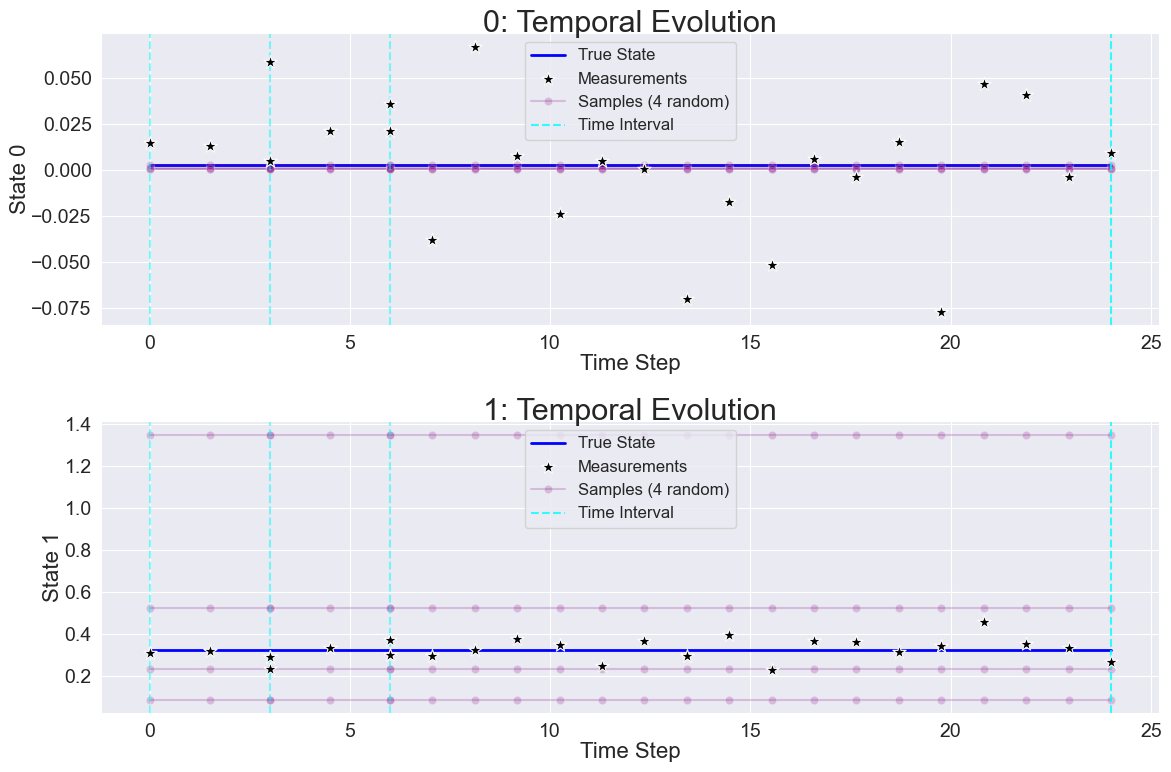

In [14]:
mm2_load.get_data(tf=24)
mm2_load.forward_solve()
mm2_load.plot_states()

### Tests

In [ ]:
import pandas as pd

def load(self, path):
    """
    Load model state from file

    """
    with pd.HDFStore(path, mode="r") as store:

        all_data = [None] * 3
        res = {}
        to_rem = []
        for key, val in store.keys():
            if v_type := type(val) == pd.DataFrame:
                val = [d[1].reset_index(
                    level=0, drop=True).dropna(axis=1)
                       for d in store[field].groupby(level=0)]
                setattr(self, field, val)

        logger.info('Setting info attributes')
        info_d = store["info"].to_dict()
        for k, v in info_d.items():
            logger.debug(f'Setting attr {k} to {v}')
            val = info.pop(k)
            setattr(self, k, v)

def save(self, path):
    """
    Save model state to file
    """
    info_dict = _info_dict(self)

    with pd.HDFStore(path, mode="w") as store:

        to_rem = []
        for key, val in info_dict.items():
            if v_type := type(val) == list and len(val) > 0:
                if all([type(v) == np.ndarray for v in val]):
                    val = [pd.DataFrame(v) for v in val]
                if all([type(v) == pd.DataFrame for v in val]):
                    val = pd.concat(val, keys=[f"{i}" for i in range(len(val))])
                    v_type = pd.DataFrame
            if v_type == pd.DataFrame:
                store.put(key, val)
                to_rem.append(key)

        for key in to_rem:
            _ = info_dict.pop(key)

        store.put("info", pd.Series(info_dict))

def _info_dict(self):
    """
    """
    # TODO: Clean this up, this is bruter force.
    # Could store this in a table
    allowable_types = [int, float, str, bool, list, pd.DataFrame, np.ndarray]
    info_dict = dict([(x, getattr(self, x)) for x in dir(self)
            if type(getattr(self, x)) in allowable_types
            and not x.startswith('_')
            and not x.startswith('n_')
            and not x.isupper()])

    return info_dict

In [ ]:
_info_dict(mm2).keys()

dict_keys(['data', 'lam_true', 'measurement_noise', 'p', 'sample_ts', 'samples', 'samples_xf', 'solve_ts', 'state_idxs', 'x0'])

In [ ]:
save(mm2, 'test.h5')

/var/folders/_1/y1tmd_l95j903jlk5yydl1f40000gn/T/ipykernel_91150/454048888.py:48: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  store.put("info", pd.Series(info_dict))


In [ ]:
# res = load(mm2, 'test.h5')

with pd.HDFStore('test.h5', 'r') as store:
    print(list(zip(store.keys(), [type(store[key]) for key in store.keys()])))
    print(store['info'].keys())


[('/data', <class 'pandas.core.frame.DataFrame'>), ('/info', <class 'pandas.core.series.Series'>), ('/samples', <class 'pandas.core.frame.DataFrame'>), ('/samples_xf', <class 'pandas.core.frame.DataFrame'>)]
Index(['lam_true', 'measurement_noise', 'p', 'sample_ts', 'solve_ts',
       'state_idxs', 'x0'],
      dtype='object')


In [ ]:
mm2_load = load('test.h5')

TypeError: load() missing 1 required positional argument: 'path'

In [ ]:
res[0].to_numpy()

array([[7.72030331e-03, 2.50812879e-02],
       [1.84078638e-04, 1.20871121e-01],
       [2.19852876e-04, 2.02743549e-01],
       [8.60053980e-04, 1.80895423e-01]])

In [ ]:
res['samples'][1]

NameError: name 'res' is not defined

In [ ]:
# split all_d by its key


# reset index to just second in multi index
dfs[0].reset_index(level=0, drop=True, inplace=True)
dfs[0]

NameError: name 'dfs' is not defined

In [ ]:
test = mon.Monomial2D(file='mm2.h5')

TypeError: Monomial2D.__init__() missing 1 required positional argument: 'p'

In [ ]:
import pandas as pd 

with pd.HDFStore('mm2.h5', mode="r") as store:
        # Check if samples are in store and store isn't empty
        if "samples" in store and len(store["samples"]) > 0:
            samples = store["samples"]
        # same for data
        if "data" in store and len(store["data"]) > 0:
            data = store["data"]

        # info = _load_dict(store["info"].to_dict())

In [ ]:
samples

,lam_0,lam_1,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5
0,0.416604,1.017069,0.012549,1.088307,0.012549,1.088307,0.012549,1.088307
1,0.419805,1.045174,0.013039,1.247221,0.013039,1.247221,0.013039,1.247221
2,0.201443,0.690080,0.000332,0.156493,0.000332,0.156493,0.000332,0.156493
3,0.199163,0.438758,0.000313,0.016260,0.000313,0.016260,0.000313,0.016260
4,0.297398,0.778137,0.002326,0.285286,0.002326,0.285286,0.002326,0.285286
...,...,...,...,...,...,...,...,...
95,0.433545,0.956192,0.015317,0.799330,0.015317,0.799330,0.015317,0.799330
96,0.444513,0.603777,0.017355,0.080238,0.017355,0.080238,0.017355,0.080238
97,0.315842,0.480740,0.003143,0.025677,0.003143,0.025677,0.003143,0.025677
98,0.383559,0.547176,0.008302,0.049050,0.008302,0.049050,0.008302,0.049050


# MUD Estimate

TODO: Test for MUD Estimates

In [ ]:
import matplotlib.pyplot as plt
import pydci.consistent_bayes.PCAMUDProblem as pcp
import importlib

importlib.reload(pcp)

# NOTE: do not pass in Model classes data dataframe -> This contains all timesteps of the true signal
prob = pcp.PCAMUDProblem(
    res2["samples"], res2["data"], mm2.measurement_noise, pi_in=pi_in
)
prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5,lam_0,lam_1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.002083,1.228081,0.002083,1.228081,0.002083,1.228081,0.290902,1.041946
1,1.0,0.0,0.0,0.0,0.0,0.0,0.004373,0.329216,0.004373,0.329216,0.004373,0.329216,0.337404,0.800749
2,1.0,0.0,0.0,0.0,0.0,0.0,0.010594,1.277716,0.010594,1.277716,0.010594,1.277716,0.402726,1.050236
3,1.0,0.0,0.0,0.0,0.0,0.0,0.003097,0.151103,0.003097,0.151103,0.003097,0.151103,0.314904,0.685259
4,1.0,0.0,0.0,0.0,0.0,0.0,0.000144,0.038116,0.000144,0.038116,0.000144,0.038116,0.170407,0.520261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.0,0.0,0.0,0.0,0.0,0.001944,0.772209,0.001944,0.772209,0.001944,0.772209,0.286913,0.949614
96,1.0,0.0,0.0,0.0,0.0,0.0,0.000160,0.654660,0.000160,0.654660,0.000160,0.654660,0.174143,0.918762
97,1.0,0.0,0.0,0.0,0.0,0.0,0.007303,0.891573,0.007303,0.891573,0.007303,0.891573,0.373851,0.977308
98,1.0,0.0,0.0,0.0,0.0,0.0,0.012477,0.244511,0.012477,0.244511,0.012477,0.244511,0.416120,0.754501


## Both Principal Components

(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{\\dagger}_1 = 0.8000$',
  '$\\lambda^{MUD}_1 = 0.7593$'])

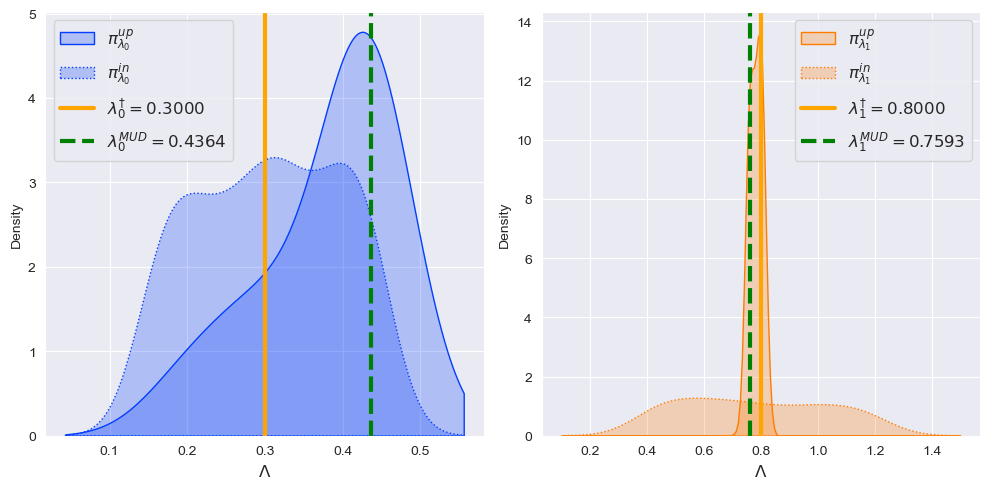

In [ ]:
prob.solve(pca_components=[0, 1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prob.plot_L(df=prob.state, param_idx=0, ax=ax[0], lam_true=[mm2.lam_true])
prob.plot_L(df=prob.state, param_idx=1, ax=ax[1], lam_true=[mm2.lam_true])

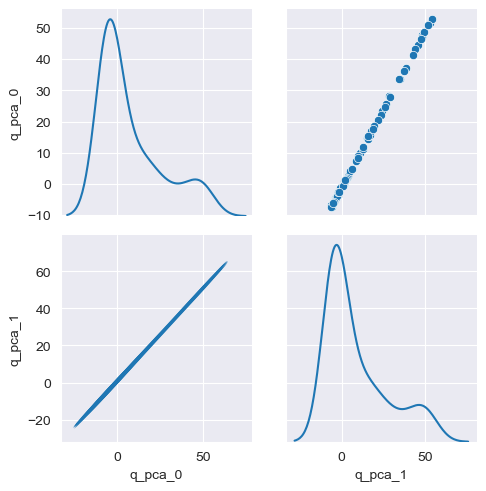

In [ ]:
prob.learned_qoi_plot()

## First Principal Component Only

(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{\\dagger}_1 = 0.8000$',
  '$\\lambda^{MUD}_1 = 0.7912$'])

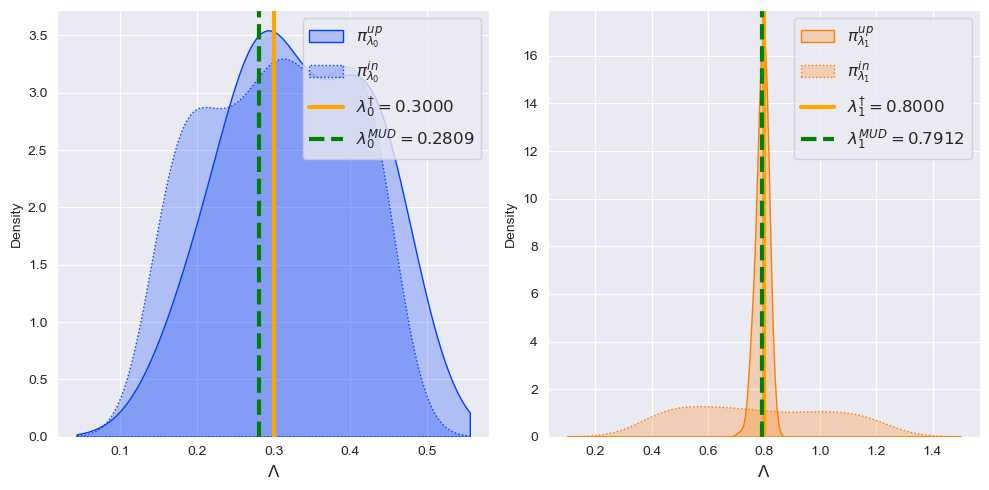

In [ ]:
prob.solve(pca_components=[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prob.plot_L(df=prob.state, param_idx=0, ax=ax[0], lam_true=[mm2.lam_true])
prob.plot_L(df=prob.state, param_idx=1, ax=ax[1], lam_true=[mm2.lam_true])

## Second Principal Component Only

(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{\\dagger}_1 = 0.8000$',
  '$\\lambda^{MUD}_1 = 0.7791$'])

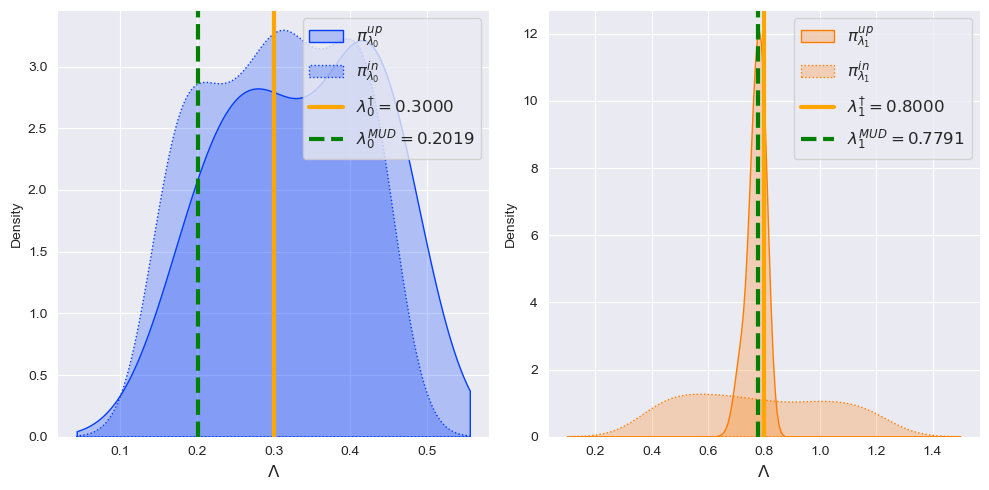

In [ ]:
prob.solve(pca_components=[1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prob.plot_L(df=prob.state, param_idx=0, ax=ax[0], lam_true=[mm2.lam_true])
prob.plot_L(df=prob.state, param_idx=1, ax=ax[1], lam_true=[mm2.lam_true])

## First State Only

(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{\\dagger}_1 = 0.8000$',
  '$\\lambda^{MUD}_1 = 1.0767$'])

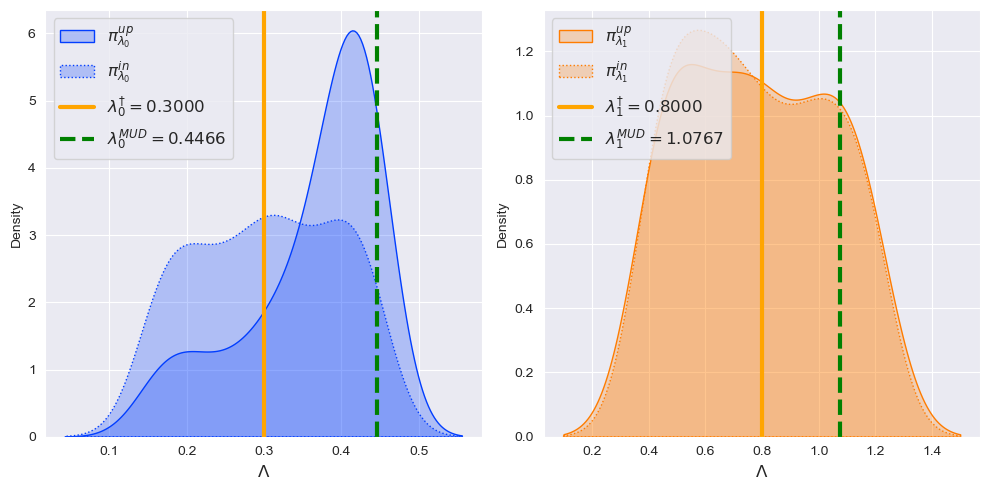

In [ ]:
prob = pcp.PCAMUDProblem(
    res2["samples"], res2["data"], mm2.measurement_noise, pi_in=pi_in
)
prob.solve(pca_mask=range(0, prob.n_qoi, 2), pca_components=[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prob.plot_L(df=prob.state, param_idx=0, ax=ax[0], lam_true=[mm2.lam_true])
prob.plot_L(df=prob.state, param_idx=1, ax=ax[1], lam_true=[mm2.lam_true])

## Second State Only

(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{MUD}_1 = 0.7791$'])

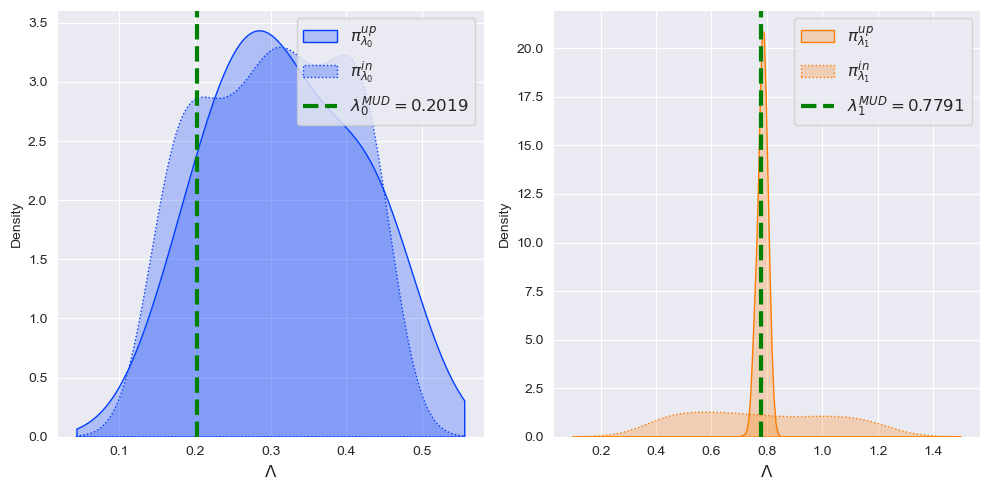

In [ ]:
prob = pcp.PCAMUDProblem(
    res2["samples"], res2["data"], mm2.measurement_noise, pi_in=pi_in
)
prob.solve(pca_mask=range(1, prob.n_qoi, 2), pca_components=[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prob.plot_L(df=prob.state, param_idx=0, ax=ax[0])
prob.plot_L(df=prob.state, param_idx=1, ax=ax[1])

## Iterating Over Components

(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{\\dagger}_1 = 0.8000$',
  '$\\lambda^{MUD}_1 = 0.8016$'])

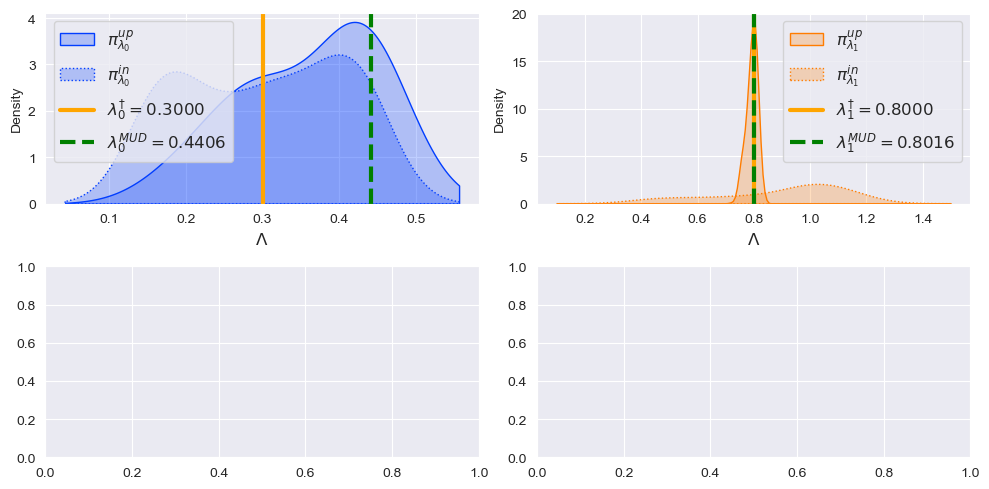

In [ ]:
prob = pcp.PCAMUDProblem(
    res2["samples"], res2["data"], mm2.measurement_noise, pi_in=pi_in
)
prob.solve_it(pca_components=[[0], [1]])

fig, ax = plt.subplots(2, 2, figsize=(10, 5))


prob.plot_L(df=prob.state, param_idx=0, ax=ax[0][0], lam_true=[mm2.lam_true])
prob.plot_L(df=prob.state, param_idx=1, ax=ax[0][1], lam_true=[mm2.lam_true])

### Sub-selecting by state

Lets iterate on a PCA map of data only aggregated from 

Text(0.5, 1.0, '$\\lambda_{1}$ update using only state 1')

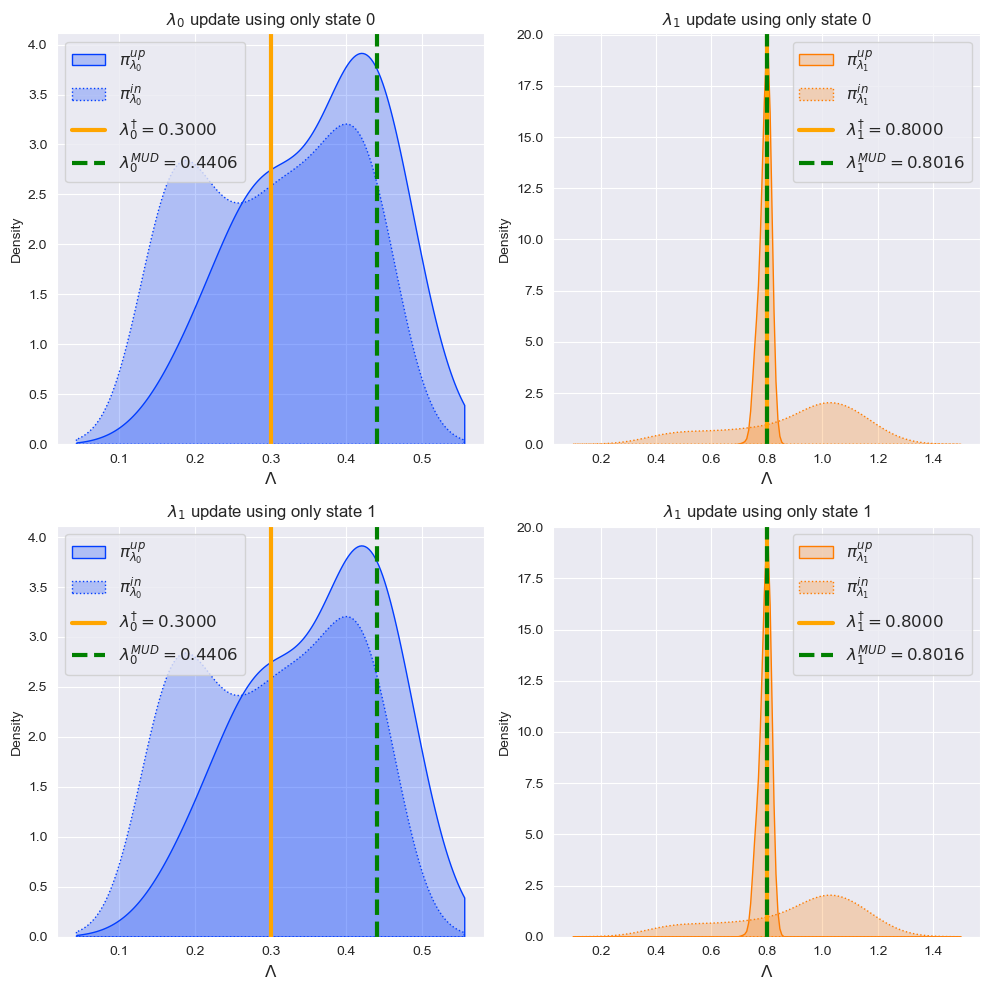

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

prob.solve(pca_mask=range(0, prob.n_qoi, 2), pca_components=[0])
prob.plot_L(df=prob.state, param_idx=0, ax=ax[0][0], lam_true=[mm2.lam_true])
ax[0][0].set_title("$\lambda_{0}$ update using only state 0")
prob.plot_L(df=prob.state, param_idx=1, ax=ax[0][1], lam_true=[mm2.lam_true])
ax[0][1].set_title("$\lambda_{1}$ update using only state 0")

prob.solve(pca_mask=range(1, prob.n_qoi, 2), pca_components=[0])
prob.plot_L(df=prob.state, param_idx=0, ax=ax[1][0], lam_true=[mm2.lam_true])
ax[1][0].set_title("$\lambda_{1}$ update using only state 1")
prob.plot_L(df=prob.state, param_idx=1, ax=ax[1][1], lam_true=[mm2.lam_true])
ax[1][1].set_title("$\lambda_{1}$ update using only state 1")

### Iterating over states

Text(0.5, 1.0, '$\\lambda_{1}$ update using only state 0')

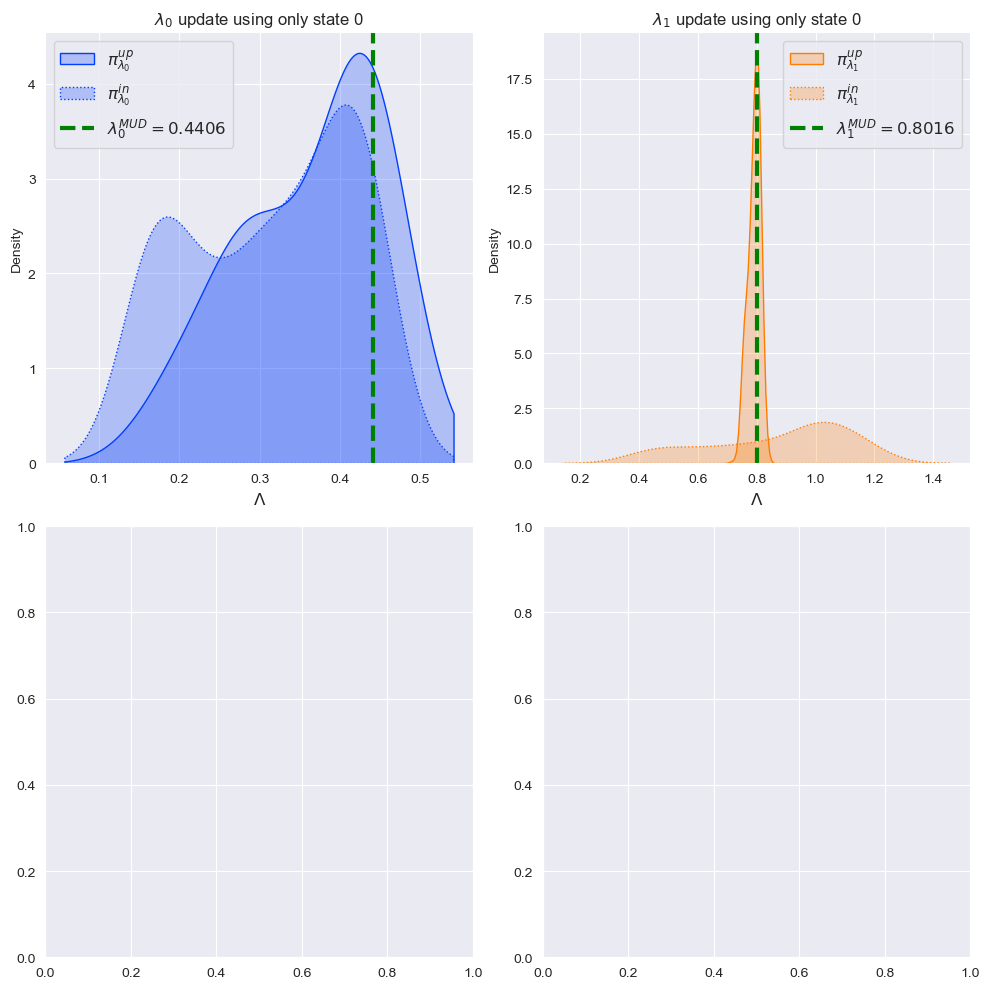

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

prob.solve_it(
    pca_splits=[range(0, prob.n_qoi, 2), range(1, prob.n_qoi, 2)], pca_components=[[0]], exp_thresh=1e30
)
prob.plot_L(df=prob.state, param_idx=0, ax=ax[0][0])
ax[0][0].set_title("$\lambda_{0}$ update using only state 0")
prob.plot_L(df=prob.state, param_idx=1, ax=ax[0][1])
ax[0][1].set_title("$\lambda_{1}$ update using only state 0")

# Estimate Methods

In [ ]:
from pydci.examples.monomial import Monomial2D

mm2 = Monomial2D(5)
mm2.estimate_params([5, 10])
mm2.plot_states()

NotImplementedError: estimate_params() base class skeleton.

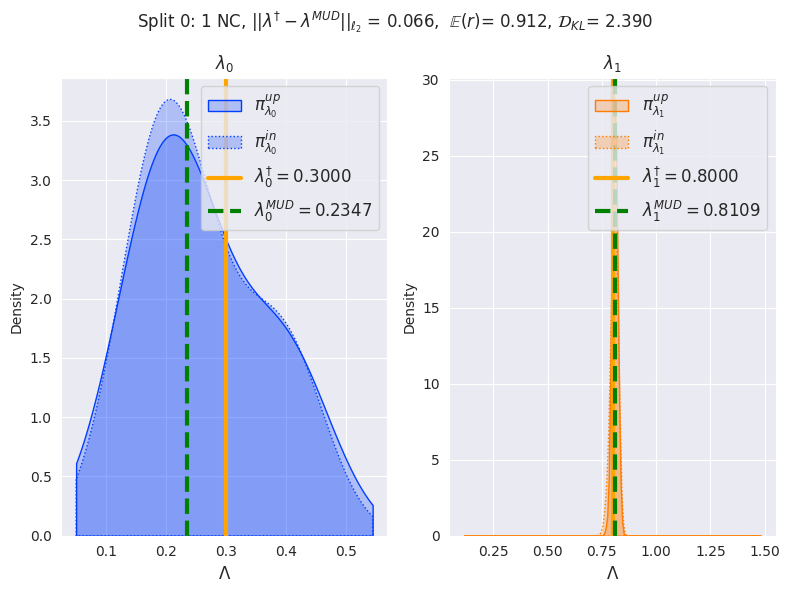

In [ ]:
mm2.probs[0].param_density_plots(lam_true=mm2.lam_true, base_size=6)

# Sequential Parameter Estimation - AKA Data Assimilation

Sequential (non-split) estimation where we can re-sample and assimilate observed data into our simulated samples between iterations.

TODO: Do this with new class that separates model and `SequentialProblem` class.

In [ ]:
from pydci.log import logger, enable_log
from pydci import SplitSequentialProblem

enable_log()

from pydci import Model
import importlib

importlib.reload(Model)
import pdb
import numpy as np
import matplotlib.pyplot as plt


class Monomial2D(Model.DynamicModel):
    def __init__(
        self,
        p,
        x0=[0, 0],  # Note in the constant monomial case, initial state won't matter
        lam_true=[0.3, 0.8],
        solve_ts=1.0,
        sample_ts=1.1,
        measurement_noise=0.05,
        **kwargs,
    ):
        self.p = p
        super().__init__(
            x0,
            lam_true,
            solve_ts=solve_ts,
            sample_ts=sample_ts,
            measurement_noise=measurement_noise,
            **kwargs,
        )

    def forward_model(
        self,
        x0,
        times,
        lam,
    ):
        """
        Monomial Forward Model

        Static in time (tim array ignored)
        """
        res = np.repeat(np.array([[lam[0] ** self.p, lam[1] ** self.p]]), 1, axis=1)
        return res

    def plot_states(
        self,
    ):
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        for i, ax in enumerate(ax):
            self.plot_state(state_idx=i, ax=ax)
            ax.set_title(f"{i}: Temporal Evolution")


mm2 = Monomial2D(5)
lam = mm2.get_uniform_initial_samples(num_samples=100, scale=0.5)
args = mm2.forward_solve(5.0, samples=lam)


class SequentialProblem:
    def __init__(self, model):
        self.model = model
        self.probs = []

    def solve(self, time_windows, num_samples=100, diff=0.5, splits_per=1):
        pi_in = None
        samples = self.model.get_uniform_initial_samples(
            num_samples=num_samples, scale=diff
        )
        for t in time_windows:
            logger.info(f"Starting iteration from {self.model.t0} to {t}")
            args = self.model.forward_solve(t, samples=samples)
            logger.info(f"Solving inverse problem")
            prob = SplitSequentialProblem(
                args["samples"], args["data"], args["std_dev"], pi_in=pi_in
            )
            prob.solve(num_splits=splits_per)
            logger.info(f"Drawing samples from updated distribution")
            samples = prob.sample_dist(num_samples=num_samples)
            self.probs.append(prob)

[04/14/23 17:07:30] INFO     Logger initialized                                                           ]8;id=599938;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=777126;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py#78\78]8;;\

                    INFO     Drawing 100 from uniform at:                                              ]8;id=775114;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=50215;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#242\242]8;;\
                                     loc: [0.15 0.4 ]                                                              
                                     scale: [0.3 0.8]                                                              

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (37564.7


In [ ]:
mm2 = Monomial2D(5)
time_windows = [5, 10, 15]
seq_prob = SequentialProblem(mm2)

seq_prob.solve(time_windows)

                    INFO     Drawing 100 from uniform at:                                              ]8;id=251698;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=924042;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#242\242]8;;\
                                     loc: [0.15 0.4 ]                                                              
                                     scale: [0.3 0.8]                                                              

                    INFO     Starting iteration from 0.0 to 5                                      ]8;id=638334;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=632493;file:///tmp/ipykernel_1785648/4009830505.py#76\76]8;;\

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (34279.0


                    INFO     Solving inverse problem                                               ]8;id=172052;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=191165;file:///tmp/ipykernel_1785648/4009830505.py#78\78]8;;\

                    INFO     Starting sequential algorithm with 1                     ]8;id=48128;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=637710;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#191\191]8;;\

                    INFO     Re-initializing problem with split #0                    ]8;id=45045;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=911787;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#193\193]8;;\

                    INFO     all: Trying 1 qoi combs.                                 ]8;id=989953;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=860151;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#207\207]8;;\

                    INFO     Trying comb of size 10: 1111111111                       ]8;id=1751;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=282681;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#210\210]8;;\

                    INFO     Solving using 1 components                                        ]8;id=773283;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=613539;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_in by computing KDE on lam                            ]8;id=99443;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=192294;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#189\189]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=348458;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=412705;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=538505;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=811687;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=322054;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=573675;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=932305;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=268934;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 1 components                                        ]8;id=540288;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=956727;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=774955;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=489960;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=529432;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=193792;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=939615;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=961710;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=935558;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=480926;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Drawing samples from updated distribution                             ]8;id=588109;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=229441;file:///tmp/ipykernel_1785648/4009830505.py#81\81]8;;\

                    INFO     Starting iteration from 5.0 to 10                                     ]8;id=448496;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=351776;file:///tmp/ipykernel_1785648/4009830505.py#76\76]8;;\

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (52740.2


                    INFO     Solving inverse problem                                               ]8;id=427782;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=904155;file:///tmp/ipykernel_1785648/4009830505.py#78\78]8;;\

                    INFO     Starting sequential algorithm with 1                     ]8;id=496446;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=388746;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#191\191]8;;\

                    INFO     Re-initializing problem with split #0                    ]8;id=769149;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=622031;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#193\193]8;;\

                    INFO     all: Trying 1 qoi combs.                                 ]8;id=275362;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=604733;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#207\207]8;;\

                    INFO     Trying comb of size 10: 1111111111                       ]8;id=130143;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=404692;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#210\210]8;;\

                    INFO     Solving using 1 components                                        ]8;id=618482;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=946105;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_in by computing KDE on lam                            ]8;id=562655;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=907678;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#189\189]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=786857;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=955923;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=615813;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=413153;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=841445;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=201406;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=620106;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=993753;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 1 components                                        ]8;id=125078;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=525501;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=9879;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=650475;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=36221;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=899227;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=516401;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=802956;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=173292;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=289097;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Drawing samples from updated distribution                             ]8;id=112838;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=965282;file:///tmp/ipykernel_1785648/4009830505.py#81\81]8;;\

                    INFO     Starting iteration from 10.0 to 15                                    ]8;id=298845;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=161876;file:///tmp/ipykernel_1785648/4009830505.py#76\76]8;;\

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (23655.9


                    INFO     Solving inverse problem                                               ]8;id=180504;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=886565;file:///tmp/ipykernel_1785648/4009830505.py#78\78]8;;\

                    INFO     Starting sequential algorithm with 1                     ]8;id=611545;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=366567;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#191\191]8;;\

                    INFO     Re-initializing problem with split #0                    ]8;id=520467;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=331334;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#193\193]8;;\

                    INFO     all: Trying 1 qoi combs.                                 ]8;id=590447;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=588155;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#207\207]8;;\

                    INFO     Trying comb of size 10: 1111111111                       ]8;id=307322;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py\SplitSequentialProblem.py]8;;\:]8;id=554865;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/SplitSequentialProblem.py#210\210]8;;\

                    INFO     Solving using 1 components                                        ]8;id=964650;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=264950;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_in by computing KDE on lam                            ]8;id=430956;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=695623;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#189\189]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=237316;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=779013;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=972782;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=24624;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=556892;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=634619;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=559934;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=4786;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 1 components                                        ]8;id=912412;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=438574;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=715493;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=575935;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Solving using 2 components                                        ]8;id=445034;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py\PCAMUDProblem.py]8;;\:]8;id=3859;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/PCAMUDProblem.py#213\213]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=404453;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=667018;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Calculating pi_pr by computing KDE on q_lam                          ]8;id=624012;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py\DCIProblem.py]8;;\:]8;id=425478;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/consistent_bayes/DCIProblem.py#207\207]8;;\

                    INFO     Drawing samples from updated distribution                             ]8;id=215105;file:///tmp/ipykernel_1785648/4009830505.py\4009830505.py]8;;\:]8;id=570102;file:///tmp/ipykernel_1785648/4009830505.py#81\81]8;;\